# 0. Imports & inputs

In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from solcore.structure import Junction
from solcore.solar_cell import SolarCell
from solcore.analytic_solar_cells.diode_equation import iv_2diode
from solcore.analytic_solar_cells.IV import iv_multijunction
from solcore.solar_cell_solver import default_options, solar_cell_solver
import pprint
import os
from datetime import datetime
import scipy.constants as const
import pvlib
from scipy.constants import Boltzmann, e

# define the plot template
axis_label_size = 20
axis_num_size = 20
text_size = 20
title_size = 22

# define the figure size for single plot
figure_size = (6, 6)
subplot_size_1_2 = (6, 6)
long_hoz_figsize = (12, 6)
two_by_two_figsize = (12, 12)

# define the random seed for reproducibility
np.random.seed(666)

# define the number of IV curves to simulate and validate
num_curves = 3
# define the module area
module_area = 2 # m2
# define the number of cells in series and parallel
num_s_cells = 72
num_p_cells = 2

# define the range of Rs, Rsh, J01 J02, IL, T for the simulation
Rsmin = 0.1  # Ohm, from the modules I have
Rshmin = 200  # Ohm, from the modules I have
Rsmax = 0.4  # Ohm, from the modules I have
Rshmax = 1200  # Ohm, from the modules I have
J01min = 1e-14  # A/m2, from PV education range
J01max = 1e-8  # A/m2, from PV education range
J02min = 1e-12  # A/m2, from PV education range
J02max = 1e-6  # A/m2, from PV education range
ILmin = 8  # A/m2, from the modules I have
ILmax = 15  # A/m2, from the modules I have
Tmin = 273  # K, from the modules I have
Tmax = 343  # K, from the modules I have
N_param = 1000 # parameter sample size

# print out the default options
print("Default options:")
# Pretty‑print the entire defaults dict:
pprint.pprint(default_options)

# define the folder to save data
save_folder = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\2_diode_models"

# define the function to calculate the I0 at MPPT
def calc_I0(I, V, Rs, Rsh, n, N, vth):
    # calculate the exponential term
    exp_term = np.exp(-(V + I * Rs) / (n * N * vth))
    # calculate the fraction term
    frac_term = n * N * vth / V
    # calculate hte numerator
    numerator = I*(1 + Rs/Rsh) - V/Rsh
    # calculate the denominator
    denominator = 1 - I * Rs / V
    # put them together
    I0 = numerator / denominator * frac_term * exp_term
    return I0

# define the function to calculate IL at MPPT
def calc_IL(I, V, Rs, Rsh, n, N, vth, I0):
    # calculate the first term
    first_term = I * (1 + Rs/Rsh)
    # calculate the second term
    second_term = V / Rsh
    # calculate the third term
    third_term = I0*(np.exp((V + I * Rs) / (n * N * vth)) - 1)
    # put them together
    IL = first_term + second_term + third_term
    return IL

c:\Users\z5183876\AppData\Local\Programs\Python\Python313\Lib\site-packages\solcore\registries.py:73: UserWarning: Optics solver 'RCWA' will not be available. An installation of S4 has not been found.
  warn(


Default options:
State([('T_ambient', 298),
       ('T', 298),
       ('wavelength',
        array([3.000e-07, 3.060e-07, 3.120e-07, 3.180e-07, 3.240e-07, 3.300e-07,
       3.360e-07, 3.420e-07, 3.480e-07, 3.540e-07, 3.600e-07, 3.660e-07,
       3.720e-07, 3.780e-07, 3.840e-07, 3.900e-07, 3.960e-07, 4.020e-07,
       4.080e-07, 4.140e-07, 4.200e-07, 4.260e-07, 4.320e-07, 4.380e-07,
       4.440e-07, 4.500e-07, 4.560e-07, 4.620e-07, 4.680e-07, 4.740e-07,
       4.800e-07, 4.860e-07, 4.920e-07, 4.980e-07, 5.040e-07, 5.100e-07,
       5.160e-07, 5.220e-07, 5.280e-07, 5.340e-07, 5.400e-07, 5.460e-07,
       5.520e-07, 5.580e-07, 5.640e-07, 5.700e-07, 5.760e-07, 5.820e-07,
       5.880e-07, 5.940e-07, 6.000e-07, 6.060e-07, 6.120e-07, 6.180e-07,
       6.240e-07, 6.300e-07, 6.360e-07, 6.420e-07, 6.480e-07, 6.540e-07,
       6.600e-07, 6.660e-07, 6.720e-07, 6.780e-07, 6.840e-07, 6.900e-07,
       6.960e-07, 7.020e-07, 7.080e-07, 7.140e-07, 7.200e-07, 7.260e-07,
       7.320e-07, 7.380e-07, 7.

# 1. Parameter simulation

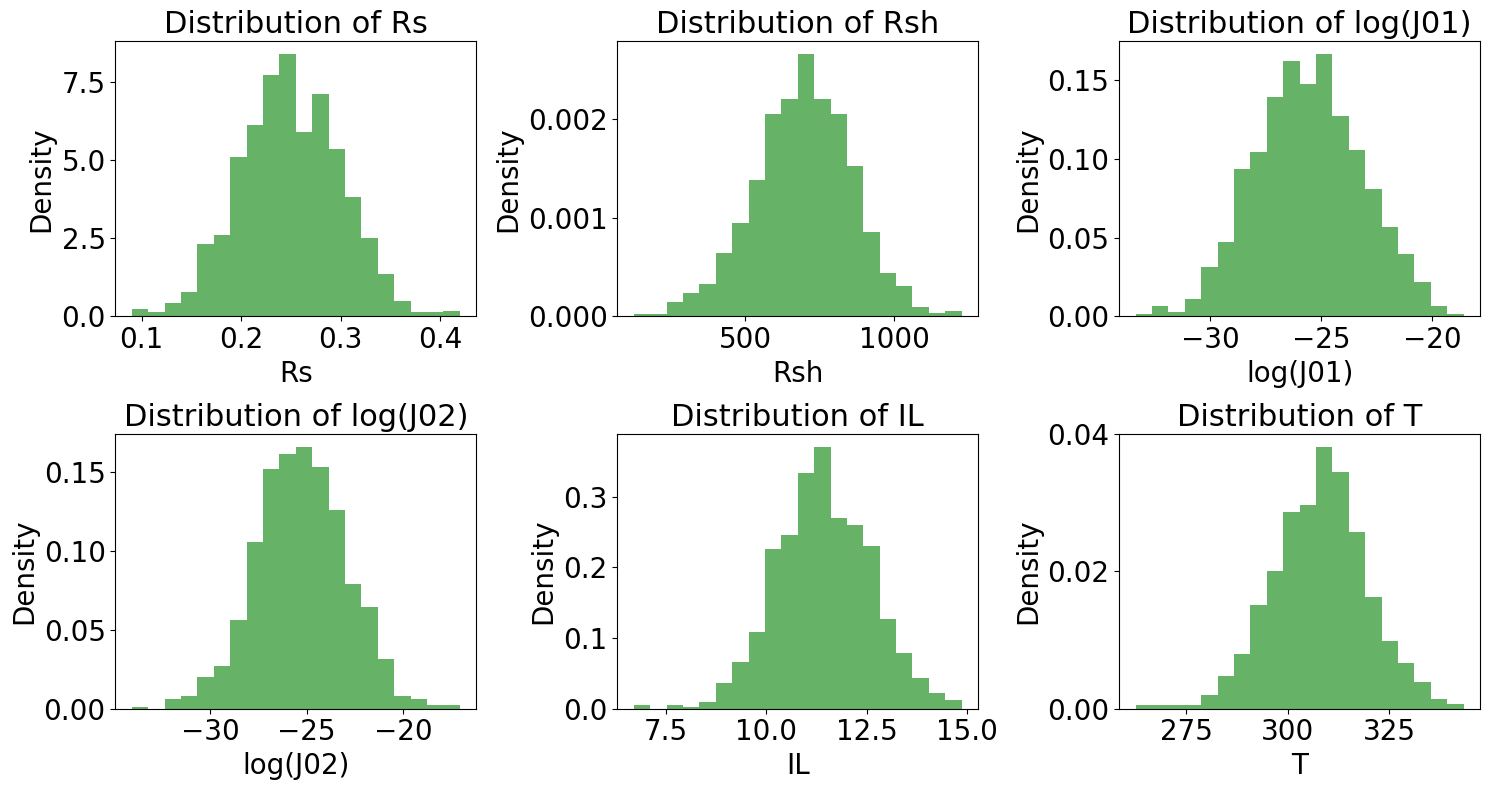

         Rs          Rsh           J01           J02         IL           T
0  0.286867  1201.018687  2.966182e-12  1.028255e-12  12.545864  327.915089
1  0.255019   762.202168  4.151236e-10  1.285921e-10  11.858645  316.613368
2  0.219946   692.879747  8.097733e-11  2.455965e-14  12.847211  323.712638


In [3]:
# Generate your parameter distributions (linear space)
for param in ['Rs', 'Rsh', 'IL', 'T']:
    mean     = (eval(param + 'max') + eval(param + 'min')) / 2
    std      = (eval(param + 'max') - eval(param + 'min')) / 6
    globals()[param + '_values'] = np.random.normal(mean, std, N_param)

# Special handling for J01 and J02: sample log-values (as before)
for param in ['J01', 'J02']:
    log_min   = np.log(eval(param + 'min'))
    log_max   = np.log(eval(param + 'max'))
    mean_log  = (log_max + log_min) / 2
    std_log   = (log_max - log_min) / 6
    log_vals  = np.random.normal(mean_log, std_log, N_param)
    globals()[param + '_values'] = np.exp(log_vals)

# Plotting all six on a 2×3 grid of subplots, 
# but for J01/J02 we plot their natural log
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for ax, param in zip(axes, ['Rs', 'Rsh', 'J01', 'J02', 'IL', 'T']):
    values = globals()[param + '_values']
    if param in ['J01', 'J02']:
        # take natural log for plotting
        values = np.log(values)
        xlabel = f'log({param})'
        title  = f'Distribution of log({param})'
    else:
        xlabel = param
        title  = f'Distribution of {param}'
    
    ax.hist(values,
            bins=20,
            density=True,
            alpha=0.6,
            color='g')
    ax.set_title(title, fontsize=title_size)
    ax.set_xlabel(xlabel, fontsize=axis_label_size)
    ax.set_ylabel('Density', fontsize=axis_label_size)
    ax.tick_params(axis='both', labelsize=axis_num_size)

plt.tight_layout()
plt.show()

# resample num_curves number of times from the distributions, create a DataFrame
# Draw num_curves samples from each _values array
samples = {}
for param in ['Rs', 'Rsh', 'J01', 'J02', 'IL', 'T']:
    samples[param] = np.random.choice(
        globals()[param + '_values'],
        size=num_curves,
        replace=True
    )

# Build DataFrame
df = pd.DataFrame(samples)

# print the head
print(df)


# 2. Two diode model IV curve generation

## 2.1. With Rs

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


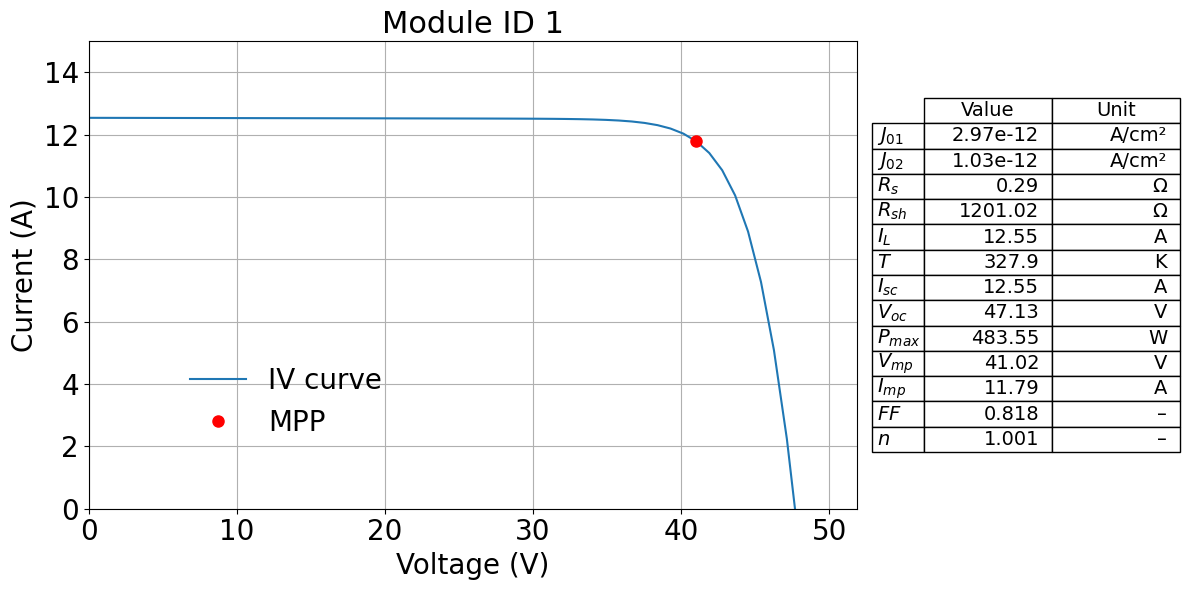

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


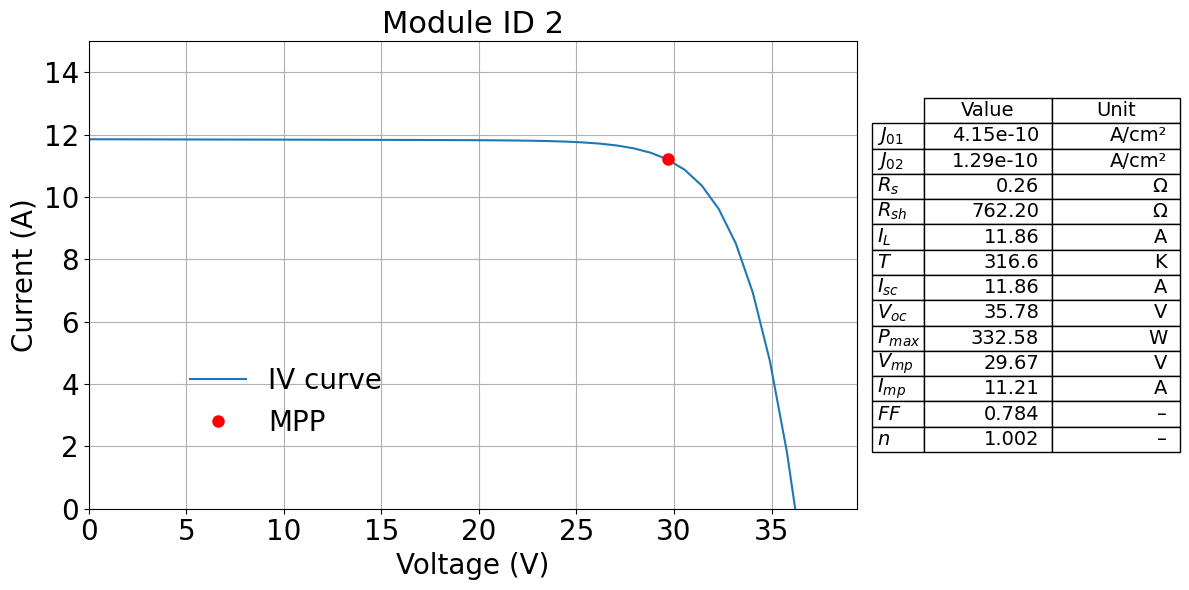

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


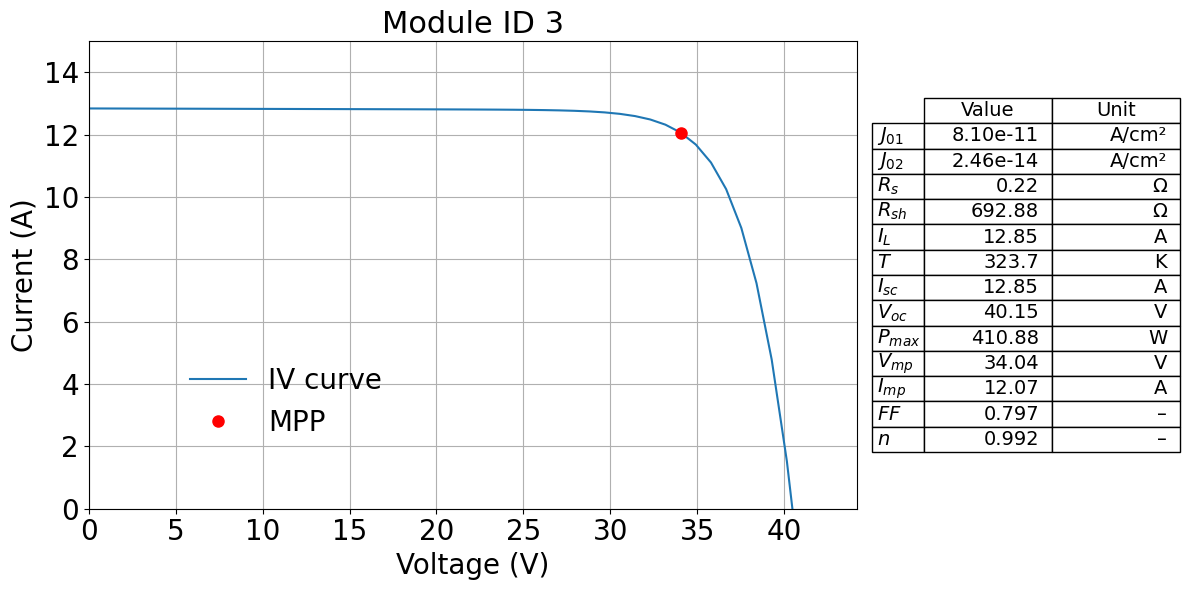

In [4]:
# %%
for index, row in df.iterrows():
    # Unpack
    Rs, Rsh = row['Rs'], row['Rsh']
    J01, J02 = row['J01'], row['J02']        # A/cm²
    IL       = row['IL']                     # A
    T        = row['T']                      # K
    module_ID = f"{index+1}"

    # Half‑cell area
    A_hcell_m2  = module_area / (num_s_cells*num_p_cells)     # m²
    A_hcell_cm2 = A_hcell_m2 * 1e4                            # cm²

    # Build 2‑diode junction
    junction = Junction(
        kind='2D', T=T,
        j01=J01, j02=J02, n1=1.0, n2=2.0,
        R_shunt = (Rsh/num_s_cells*num_p_cells)*A_hcell_cm2,
        jsc     = (IL/num_p_cells)/A_hcell_cm2,
        A       = A_hcell_cm2
    )
    opts = default_options.copy()
    opts.update({
        'internal_voltages': np.linspace(0, 0.8, 10000),
        'light_iv': True, 'T': T, 'mpp': True
    })
    iv_2diode(junction, opts)

    # build the cell object
    cell = SolarCell(
        [junction],
        R_series=Rs, R_shunt=Rsh, T=T,
        A=A_hcell_cm2,
    )
    # solve the cell IV
    # iv_multijunction(cell, opts)
    solar_cell_solver(cell, 'iv', opts)

    # extract the IV data
    V_cell, I_cell = cell.iv['IV']


    # Extract IV arrays
    V_module  = (V_cell * num_s_cells)       # V
    I_module  = (I_cell*num_p_cells)*A_hcell_cm2                  # A
    # mask  = I_module > -0.1
    # V_module = V_module[mask]
    # I_module = I_module[mask]

    # # 1) find the crossing index: where I[i] > 0 and I[i+1] < 0
    # cross_idxs = np.where((I_module[:-1] > 0) & (I_module[1:] < 0))[0]

    # if len(cross_idxs) == 0:
    #     # no crossing found: keep everything
    #     mask = np.ones_like(I_module, dtype=bool)
    # else:
    #     # take the first crossing
    #     i = cross_idxs[0]
    #     # build a mask that keeps points up through i+1
    #     mask = np.zeros_like(I_module, dtype=bool)
    #     mask[: i + 2] = True

    # # apply it
    # V_module_trim = V_module[mask]
    # I_module_trim = I_module[mask]


    # Performance metrics
    I_sc = I_module[0]
    V_oc = V_module[np.where(I_module > 0)[0][-1]]
    P    = V_module * I_module
    idx  = np.argmax(P)
    P_max= P[idx]
    V_mp = V_module[idx]
    I_mp = I_module[idx]
    FF   = P_max/(V_oc*I_sc)

    # --- Scalar n extraction (including Rsh) ---
    Vt = Boltzmann * T / e
    # Convert J0 densities from A/cm² → A/m²
    J01_SI = J01 * 1e4
    J02_SI = J02 * 1e4
    # Module-level I0 (A)
    I0_module = (J01_SI + J02_SI) * A_hcell_m2 * num_p_cells
    # I0_module = 1e-90
    # Use I_ph ≈ I_sc
    numerator = I_sc - V_oc/Rsh
    n_scalar  = V_oc / (Vt * np.log(numerator/I0_module + 1))/num_s_cells

    # Plot and table
    fig, (ax_curve, ax_table) = plt.subplots(
        1, 2,
        figsize=(figure_size[0]*2, figure_size[1]),
        gridspec_kw={'width_ratios': [3, 1]}
    )
    ax_curve.plot(V_module, I_module, label='IV curve')
    ax_curve.plot(V_mp, I_mp, 'o',
                  markeredgecolor='red', markerfacecolor='red',
                  markersize=8, label='MPP')
    ax_curve.set_xlabel('Voltage (V)', fontsize=axis_label_size)
    ax_curve.set_ylabel('Current (A)', fontsize=axis_label_size)
    ax_curve.set_title('Module ID ' + module_ID, fontsize=title_size)
    ax_curve.tick_params(labelsize=axis_num_size)
    ax_curve.grid(True)
    ax_curve.set_ylim(0, 15)
    ax_curve.set_xlim(0, V_oc*1.1)
    ax_curve.legend(fontsize=text_size, loc='lower left', bbox_to_anchor=(0.1,0.1), frameon=False)

    # Table data (now including n_scalar)
    table_data = [
        [f'{J01:.2e}',   'A/cm²'],
        [f'{J02:.2e}',   'A/cm²'],
        [f'{Rs:.2f}',    'Ω'],
        [f'{Rsh:.2f}',   'Ω'],
        [f'{IL:.2f}',    'A'],
        [f'{T:.1f}',     'K'],
        [f'{I_sc:.2f}',  'A'],
        [f'{V_oc:.2f}',  'V'],
        [f'{P_max:.2f}', 'W'],
        [f'{V_mp:.2f}',  'V'],
        [f'{I_mp:.2f}',  'A'],
        [f'{FF:.3f}',    '–'],
        [f'{n_scalar:.3f}','–']
    ]
    row_labels = [
        r'$J_{01}$', r'$J_{02}$', r'$R_{s}$',  r'$R_{sh}$',
        r'$I_{L}$',  r'$T$',      r'$I_{sc}$', r'$V_{oc}$',
        r'$P_{max}$',r'$V_{mp}$', r'$I_{mp}$', r'$FF$',
        r'$n$'
    ]
    col_labels = ['Value','Unit']

    ax_table.axis('off')
    tbl = ax_table.table(
        cellText=table_data,
        rowLabels=row_labels,
        colLabels=col_labels,
        loc='center'
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(14)
    tbl.scale(1, 1.5)

    plt.tight_layout()

    # Save to timestamped folder
    timestamp    = datetime.now().strftime("%Y%m%d_%H%M%S")
    curve_folder = os.path.join(save_folder, timestamp)
    os.makedirs(curve_folder, exist_ok=True)

    fig.savefig(os.path.join(curve_folder, "IV_curve.png"), dpi=300, bbox_inches='tight')
    plt.show()

    pd.DataFrame(table_data, columns=col_labels, index=row_labels).to_csv(
        os.path.join(curve_folder, "IV_curve_table.csv"),
        index=True, header=True
    )
    pd.DataFrame({'V': V_module, 'I': I_module}).to_csv(
        os.path.join(curve_folder, "IV_curve_data.csv"),
        index=False
    )

## 2.2. Without Rs

In [5]:
# # %%
# for index, row in df.iterrows():
#     # Unpack
#     Rs, Rsh = row['Rs'], row['Rsh']
#     J01, J02 = row['J01'], row['J02']        # A/cm²
#     IL       = row['IL']                     # A/m²
#     T        = row['T']                      # K

#     # Half‑cell area
#     A_hcell_m2  = module_area / (num_s_cells*num_p_cells)     # m²
#     A_hcell_cm2 = A_hcell_m2 * 1e4                            # cm²

#     # Build 2‑diode junction
#     junction = Junction(
#         kind='2D', T=T,
#         j01=J01, j02=J02, n1=1.0, n2=2.0,
#         R_shunt = (Rsh/num_s_cells*num_p_cells)*A_hcell_cm2,
#         jsc     = (IL/num_p_cells)/A_hcell_cm2,
#         A       = A_hcell_cm2
#     )
#     opts = default_options.copy()
#     opts.update({
#         'internal_voltages': np.linspace(0, 0.8, 2000),
#         'light_iv': True, 'T': T, 'mpp': True
#     })
#     iv_2diode(junction, opts)

#     # Extract IV arrays
#     V = opts['internal_voltages']
#     J = junction.iv(V)
#     I_mod = -J * A_hcell_cm2 * num_p_cells   # A
#     mask  = I_mod > -0.1
#     V_module  = V[mask] * num_s_cells        # V
#     I_module  = I_mod[mask]                  # A

#     # Performance metrics
#     I_sc = I_module[0]
#     V_oc = V_module[np.where(I_module > 0)[0][-1]]
#     P    = V_module * I_module
#     idx  = np.argmax(P)
#     P_max= P[idx]
#     V_mp = V_module[idx]
#     I_mp = I_module[idx]
#     FF   = P_max/(V_oc*I_sc)

#     # --- Scalar n extraction (including Rsh) ---
#     Vt = Boltzmann * T / e
#     # Convert J0 densities from A/cm² → A/m²
#     J01_SI = J01 * 1e4
#     J02_SI = J02 * 1e4
#     # Module-level I0 (A)
#     I0_module = (J01_SI + J02_SI) * A_hcell_m2 * num_p_cells
#     # I0_module = 1e-90
#     # Use I_ph ≈ I_sc
#     numerator = I_sc - V_oc/Rsh
#     n_scalar  = V_oc / (Vt * np.log(numerator/I0_module + 1))/num_s_cells

#     # Plot and table
#     fig, (ax_curve, ax_table) = plt.subplots(
#         1, 2,
#         figsize=(figure_size[0]*2, figure_size[1]),
#         gridspec_kw={'width_ratios': [3, 1]}
#     )
#     ax_curve.plot(V_module, I_module, label='IV curve')
#     ax_curve.plot(V_mp, I_mp, 'o',
#                   markeredgecolor='red', markerfacecolor='red',
#                   markersize=8, label='MPP')
#     ax_curve.set_xlabel('Voltage (V)', fontsize=axis_label_size)
#     ax_curve.set_ylabel('Current (A)', fontsize=axis_label_size)
#     ax_curve.set_title('2‑Diode IV Curve', fontsize=title_size)
#     ax_curve.tick_params(labelsize=axis_num_size)
#     ax_curve.grid(True)
#     ax_curve.legend(fontsize=text_size, loc='lower left', bbox_to_anchor=(0.1,0.1), frameon=False)

#     # Table data (now including n_scalar)
#     table_data = [
#         [f'{J01:.2e}',   'A/cm²'],
#         [f'{J02:.2e}',   'A/cm²'],
#         [f'{Rs:.2f}',    'Ω'],
#         [f'{Rsh:.2f}',   'Ω'],
#         [f'{IL:.2f}',    'A/m²'],
#         [f'{T:.1f}',     'K'],
#         [f'{I_sc:.2f}',  'A'],
#         [f'{V_oc:.2f}',  'V'],
#         [f'{P_max:.2f}', 'W'],
#         [f'{V_mp:.2f}',  'V'],
#         [f'{I_mp:.2f}',  'A'],
#         [f'{FF:.3f}',    '–'],
#         [f'{n_scalar:.3f}','–']
#     ]
#     row_labels = [
#         r'$J_{01}$', r'$J_{02}$', r'$R_{s}$',  r'$R_{sh}$',
#         r'$I_{L}$',  r'$T$',      r'$I_{sc}$', r'$V_{oc}$',
#         r'$P_{max}$',r'$V_{mp}$', r'$I_{mp}$', r'$FF$',
#         r'$n$'
#     ]
#     col_labels = ['Value','Unit']

#     ax_table.axis('off')
#     tbl = ax_table.table(
#         cellText=table_data,
#         rowLabels=row_labels,
#         colLabels=col_labels,
#         loc='center'
#     )
#     tbl.auto_set_font_size(False)
#     tbl.set_fontsize(14)
#     tbl.scale(1, 1.5)

#     plt.tight_layout()

#     # Save to timestamped folder
#     timestamp    = datetime.now().strftime("%Y%m%d_%H%M%S")
#     curve_folder = os.path.join(save_folder, timestamp)
#     os.makedirs(curve_folder, exist_ok=True)

#     fig.savefig(os.path.join(curve_folder, "IV_curve.png"), dpi=300, bbox_inches='tight')
#     plt.show()

#     pd.DataFrame(table_data, columns=col_labels, index=row_labels).to_csv(
#         os.path.join(curve_folder, "IV_curve_table.csv"),
#         index=True, header=True
#     )
#     pd.DataFrame({'V': V_module, 'I': I_module}).to_csv(
#         os.path.join(curve_folder, "IV_curve_data.csv"),
#         index=False
#     )

# 3. IV curve reconstruction using given method

## 3.1. IV reconstruction

   Unnamed: 0         Value   Unit
0         J01  4.150000e-10  A/cm²
1         J02  1.290000e-10  A/cm²
2          Rs  2.600000e-01      Ω
3         Rsh  7.622000e+02      Ω
4          IL  1.186000e+01      A
5           T  3.166000e+02      K
6         Isc  1.186000e+01      A
7         Voc  3.578000e+01      V
8        Pmax  3.325800e+02      W
9         Vmp  2.967000e+01      V
10        Imp  1.121000e+01      A
11         FF  7.840000e-01      –
12          n  1.002000e+00      –
MAE:  1.7369478879681717
MAPE:  4.910552622392674
MBE:  -0.412713442673457


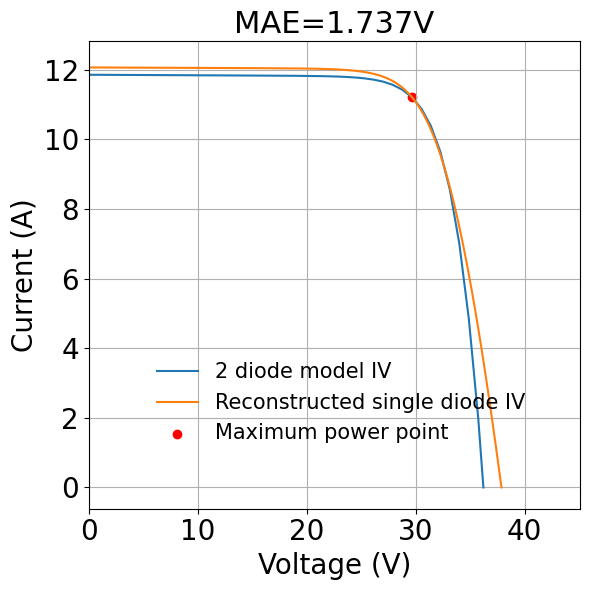

   Unnamed: 0         Value   Unit
0         J01  8.100000e-11  A/cm²
1         J02  2.460000e-14  A/cm²
2          Rs  2.200000e-01      Ω
3         Rsh  6.928800e+02      Ω
4          IL  1.285000e+01      A
5           T  3.237000e+02      K
6         Isc  1.285000e+01      A
7         Voc  4.015000e+01      V
8        Pmax  4.108800e+02      W
9         Vmp  3.404000e+01      V
10        Imp  1.207000e+01      A
11         FF  7.970000e-01      –
12          n  9.920000e-01      –
MAE:  4.1574436573632285
MAPE:  5.143272984828324
MBE:  2.3575550492715247


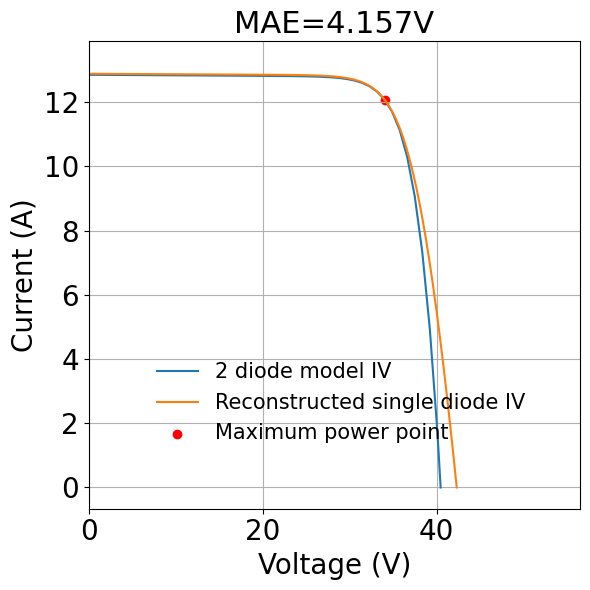

   Unnamed: 0         Value   Unit
0         J01  4.150000e-10  A/cm²
1         J02  1.290000e-10  A/cm²
2          Rs  2.600000e-01      Ω
3         Rsh  7.622000e+02      Ω
4          IL  1.186000e+01      A
5           T  3.166000e+02      K
6         Isc  1.186000e+01      A
7         Voc  3.578000e+01      V
8        Pmax  3.325800e+02      W
9         Vmp  2.967000e+01      V
10        Imp  1.121000e+01      A
11         FF  7.840000e-01      –
12          n  1.002000e+00      –
MAE:  1.7369478879681717
MAPE:  4.910552622392674
MBE:  -0.412713442673457


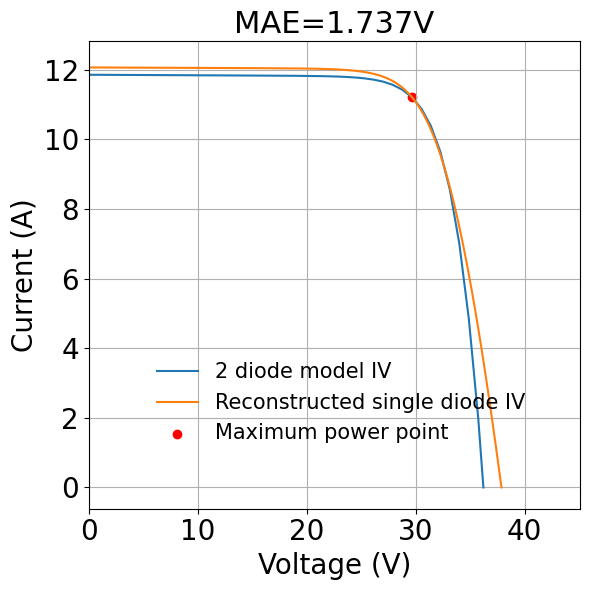

   Unnamed: 0         Value   Unit
0         J01  8.100000e-11  A/cm²
1         J02  2.460000e-14  A/cm²
2          Rs  2.200000e-01      Ω
3         Rsh  6.928800e+02      Ω
4          IL  1.285000e+01      A
5           T  3.237000e+02      K
6         Isc  1.285000e+01      A
7         Voc  4.015000e+01      V
8        Pmax  4.108800e+02      W
9         Vmp  3.404000e+01      V
10        Imp  1.207000e+01      A
11         FF  7.970000e-01      –
12          n  9.920000e-01      –
MAE:  4.1574436573632285
MAPE:  5.143272984828324
MBE:  2.3575550492715247


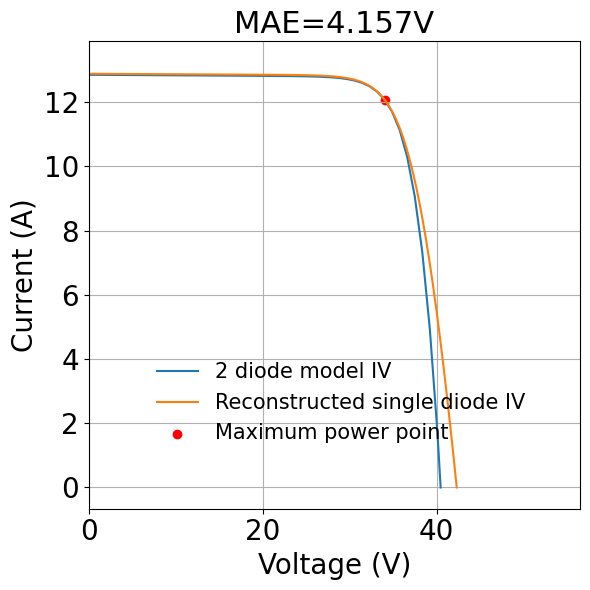

In [9]:
# initialise the list for evaluation matrix
mae_list = []
mape_list = []
mbe_list = []

# initialise the list for parameters of 2 diode model
Rs_list = []
Rsh_list = []
Vmp_list = []
Imp_list = []
T_list = []
J01_list = []
J02_list = []
n_list = []

# for each folder in save_folder check if there is a file containing "IV_curve_reconstructed"
if os.path.exists(save_folder):
    for folder in os.listdir(save_folder):
        folder_path = os.path.join(save_folder, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if "IV_curve_reconstructed" not in file:
                    # read the csv file that contains word table
                    if "IV_curve_table" in file:
                        # read the table
                        table_df = pd.read_csv(os.path.join(folder_path, file))
                        # for the first column, each row, remove any symbols including: $, _, {, }
                        table_df.iloc[:, 0] = table_df.iloc[:, 0].str.replace(r'[$_{}]', '', regex=True)
                        print(table_df)
                        # read the Rs, Rsh, n, Vmp, Imp from the table
                        Rs = table_df.iloc[2, 1]
                        Rsh = table_df.iloc[3, 1]
                        # n = 1 # n is not in the table, but we can assume it is 1 for this case
                        Vmp = table_df.iloc[9, 1]
                        Imp = table_df.iloc[10, 1]
                        # read the T
                        T = table_df.iloc[5, 1]
                        # read ideality factor n from the table
                        n = table_df.iloc[12, 1]
                        J01 = float(table_df.iloc[0, 1])
                        J02 = float(table_df.iloc[1, 1])

                        # collect the parameters for evaluation matrix
                        Rs_list.append(Rs)
                        Rsh_list.append(Rsh)
                        Vmp_list.append(Vmp)
                        Imp_list.append(Imp)
                        T_list.append(T)
                        J01_list.append(J01)
                        J02_list.append(J02)
                        n_list.append(n)


                        # calculate the required parameters
                        # calculate the thermal voltage
                        k = const.Boltzmann
                        q = const.e
                        vth = k * T / q
                        # calculate the I0
                        I0_value = calc_I0(Imp, Vmp, Rs, Rsh, n, num_s_cells, vth)
                        # calculate the IL
                        IL_value = calc_IL(Imp, Vmp, Rs, Rsh, n, num_s_cells, vth, I0_value)

                        # set up the IV curves for pvlib
                        params = {
                            'photocurrent': IL_value,
                            'saturation_current': I0_value,
                            'resistance_series': Rs,
                            'resistance_shunt': Rsh,
                            'nNsVth': n * num_s_cells * vth,
                            }
                        
                        # compute the IV curve
                        # find the v that was used in the 2 diode model IV curve, read the file 'IV_curve_data.csv' in the file
                        iv_curve_df = pd.read_csv(os.path.join(folder_path, "IV_curve_data.csv"))
                        # extract the V and I from the dataframe
                        V_2_diode = iv_curve_df['V'].values
                        I_2_diode = iv_curve_df['I'].values

                        # find the maximum current vlaue
                        I_2_diode_max = np.max(I_2_diode)
                        # add the maximum curent value times 1.03 and add to the I_2_diode array as I_2_diode_plotting
                        I_2_diode_plotting = np.sort(np.arange(0, I_2_diode_max * 1.03, 0.01))

                        # for evaluation matrix
                        # # compute the reconstructed IV
                        V_reconstructed = pvlib.pvsystem.v_from_i(
                            current=I_2_diode_plotting,
                            photocurrent=IL_value,
                            saturation_current=I0_value,
                            resistance_series=Rs,
                            resistance_shunt=Rsh,
                            nNsVth=n * num_s_cells * vth,
                            method='lambertw'
                        )
                        I_reconstructed = I_2_diode_plotting.copy()
                       
                        # interpolate for 2 diode model IV curve
                        # sort iv_curve_df by the I column
                        iv_curve_df = iv_curve_df.sort_values(by='I')
                        V_2_diode_plotting = np.interp(I_2_diode_plotting, iv_curve_df['I'], iv_curve_df['V'])

                        # for calculating the evaluation matrix, only keep the index where both 


                        # calculate the evaluatoin matrix between V2_diode and V_reconstructed
                        mae = np.mean(np.abs(V_2_diode_plotting - V_reconstructed))
                        mape = np.mean(np.abs((V_2_diode_plotting - V_reconstructed) / V_reconstructed)) * 100
                        mbe = np.mean(V_2_diode_plotting - V_reconstructed)
                        print("MAE: ", mae)
                        print("MAPE: ", mape)
                        print("MBE: ", mbe)
                        # collect into the list
                        mae_list.append(mae)
                        mape_list.append(mape)
                        mbe_list.append(mbe)

                        # plot the reconstructed IV curve with the original IV curve
                        plt.figure(figsize=figure_size)
                        plt.plot(V_2_diode_plotting, I_2_diode_plotting, label='2 diode model IV')
                        plt.plot(V_reconstructed, I_reconstructed, label='Reconstructed single diode IV')
                        # plt.scatter(V_2_diode, I_2_diode, label='Original 2 diode IV curve')
                        plt.scatter(Vmp, Imp, color='red', label='Maximum power point')
                        plt.xlabel('Voltage (V)', fontsize=axis_label_size)
                        plt.ylabel('Current (A)', fontsize=axis_label_size)
                        plt.title('MAE=' + str(round(mae, 3)) + 'V', fontsize=title_size)   
                        plt.tick_params(axis='both', labelsize=axis_num_size)
                        plt.xlim(0, )
                        plt.grid(True)
                        plt.legend(fontsize=text_size-5, loc='lower left', bbox_to_anchor=(0.1, 0.1), frameon=False)
                        plt.tight_layout()
                        plt.show()
                        

## 3.2. Evaluation matrix summary

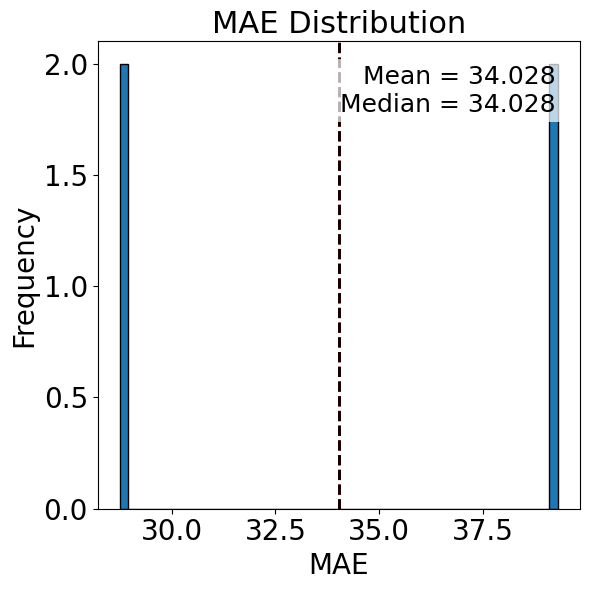

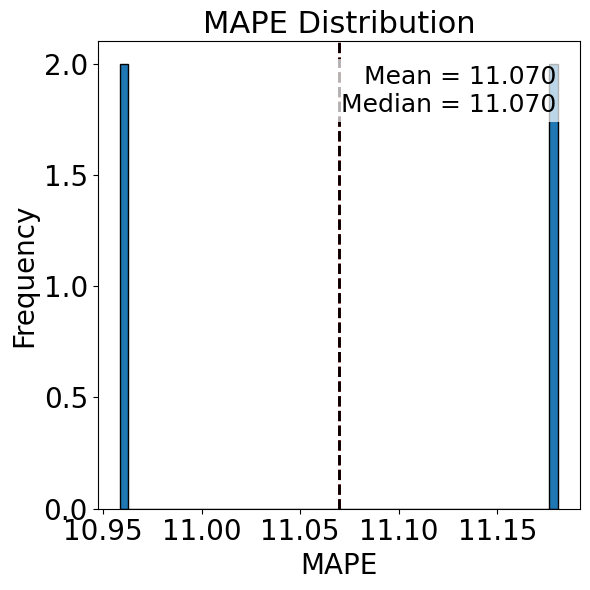

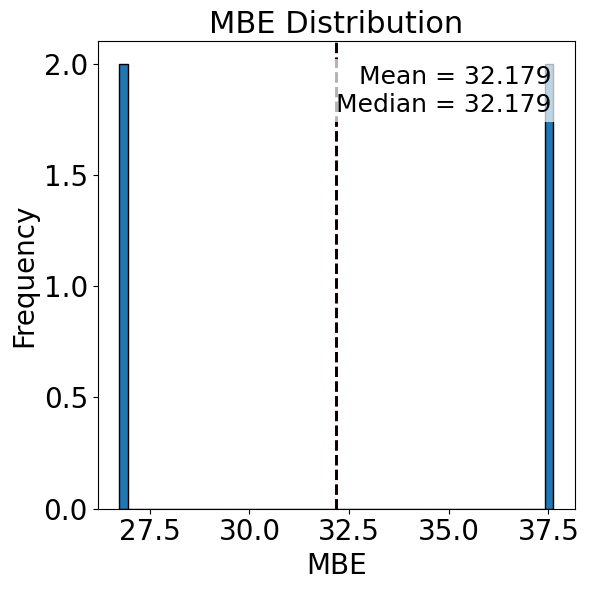

In [7]:
metrics = {
    'MAE': np.array(mae_list),
    'MAPE': np.array(mape_list),
    'MBE': np.array(mbe_list)}

for name, data in metrics.items():
    fig, ax = plt.subplots(figsize=figure_size)

    # Plot histogram
    ax.hist(data, bins=50, edgecolor='black')
    ax.set_title(f'{name} Distribution', fontsize=title_size)
    ax.set_xlabel(name, fontsize=axis_label_size)
    ax.set_ylabel('Frequency', fontsize=axis_label_size)
    ax.tick_params(axis='both', labelsize=axis_num_size)

    # Compute mean and median
    mean_val   = np.mean(data)
    median_val = np.median(data)

    # Draw vertical dashed lines
    ax.axvline(mean_val,   color='red',   linestyle='--', linewidth=2)
    ax.axvline(median_val, color='black', linestyle='--', linewidth=2)

    # Annotate mean & median in top‑right
    ax.text(
        0.95, 0.95,
        f"Mean = {mean_val:.3f}\nMedian = {median_val:.3f}",
        transform=ax.transAxes,
        ha='right', va='top',
        fontsize=text_size-2,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
    )

    plt.tight_layout()
    plt.show()